# Load Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor

from xgboost import XGBRegressor


# Load Data

In [ ]:
data = pd.read_csv("../../data/processed/extended_features/training_outlier_removed.csv", sep="\t")
X = data.drop(columns=["ActualTOW"])
y = data["ActualTOW"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Models


In [14]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2, random_state=42)
xgb_final = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2, random_state=42)
 
models = {
    "Linear Regression": (lr, {}),
    "KNN": (
        KNeighborsRegressor(),
        {
            "regressor__n_neighbors": [10],
            "regressor__weights": ["distance"]
        }
    ),
    "Decision Tree": (
        DecisionTreeRegressor(random_state=42),
        {
            "regressor__max_depth": [10],
            "regressor__min_samples_split": [2],
            "regressor__min_samples_leaf": [1]
        }
    ),
    "Random Forest": (
        rf,
        {
            "regressor__n_estimators": [200],
            "regressor__max_depth": [20],
            "regressor__min_samples_split": [2],
            "regressor__min_samples_leaf": [1]
        }
    ),
    "XGBoost": (
        xgb,
        {
            "regressor__n_estimators": [200],
            "regressor__max_depth": [6],
            "regressor__learning_rate": [0.2]
        }
    ),
    "Voting Regressor": (
        VotingRegressor([
            ("lr", lr),
            ("rf", rf),
            ("xgb", xgb)
        ]),
        {}
    ),
    "Voting Weighted": (
        VotingRegressor([
            ("lr", lr),
            ("rf", rf),
            ("xgb", xgb)
        ], weights=[1, 2, 3]),
        {}
    )
    ,
    "Stacking (Linear Regression final)": (
        StackingRegressor(
            estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
            final_estimator=LinearRegression(),
            cv=5
        ),
        {}
    ),
    "Stacking (LR + XGB only Linear Regression Final)": (
        StackingRegressor(
            estimators=[("lr", lr), ("xgb", xgb)],
            final_estimator=LinearRegression(),
            cv=5
        ),
        {}
    ),
    "Stacking (XGBoost final)": (
        StackingRegressor(
            estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
            final_estimator=xgb_final,
            cv=5
        ),
        {}
    ),
    "Stacking (LR + XGB only, XGBoost Final)": (
        StackingRegressor(
            estimators=[("lr", lr), ("xgb", xgb)],
            final_estimator=xgb_final,
            cv=5
        ),
        {}
    )
}

# Run Methods

In [15]:
results = []

for name, (model, param_grid) in models.items():
    print(f"Training: {name}")
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    if param_grid:
        grid = GridSearchCV(pipe, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        pipe.fit(X_train, y_train)
        best_model = pipe
        best_params = "default"

    y_pred = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "Best Parameters": best_params
    })

Training: Linear Regression


Training: KNN


c:\Users\huber\anaconda3\envs\ryanair_regression\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Training: Decision Tree
Training: Random Forest
Training: XGBoost
Training: Voting Regressor
Training: Voting Weighted
Training: Stacking (Linear Regression final)
Training: Stacking (LR + XGB only Linear Regression Final)
Training: Stacking (XGBoost final)
Training: Stacking (LR + XGB only, XGBoost Final)


# Tabel of results

In [16]:
results_df = pd.DataFrame(results)
print(results_df)

                                               Model        RMSE         MAE  \
0                                  Linear Regression  701.456995  494.120355   
1                                                KNN  862.983411  640.643444   
2                                      Decision Tree  966.753279  696.753022   
3                                      Random Forest  807.578506  592.713475   
4                                            XGBoost  725.925246  530.776898   
5                                   Voting Regressor  692.536370  505.682843   
6                                    Voting Weighted  708.774424  518.931490   
7                 Stacking (Linear Regression final)  675.209344  485.917740   
8   Stacking (LR + XGB only Linear Regression Final)  675.929383  485.366336   
9                           Stacking (XGBoost final)  695.374533  501.792273   
10           Stacking (LR + XGB only, XGBoost Final)  691.358052  496.232617   

                                      B

# RMSE Plot

C:\Users\huber\AppData\Local\Temp\ipykernel_2952\4290069499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", palette="viridis")


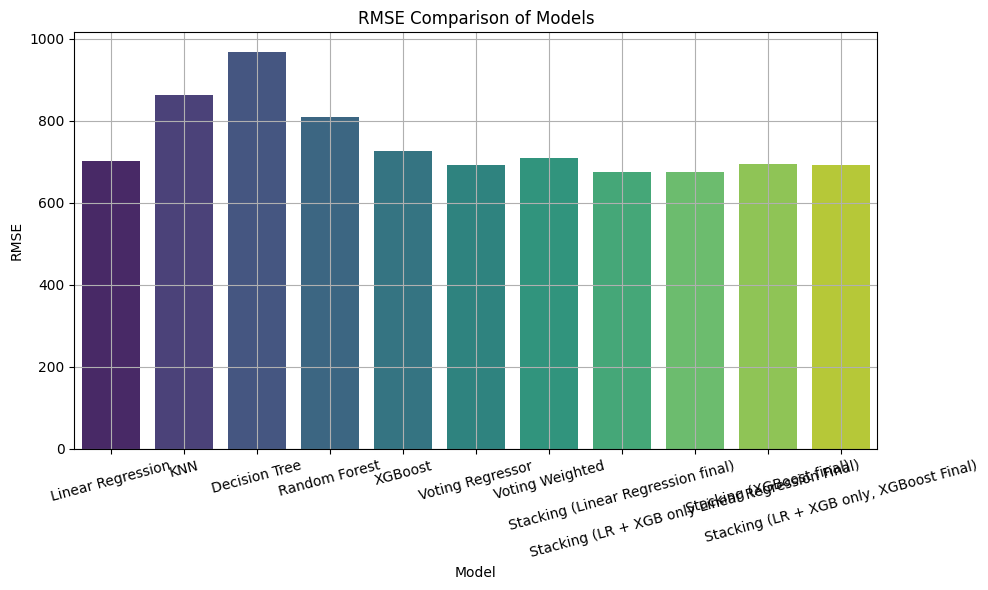

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison of Models")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE Plot

C:\Users\huber\AppData\Local\Temp\ipykernel_2952\3727563650.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAE", palette="magma")


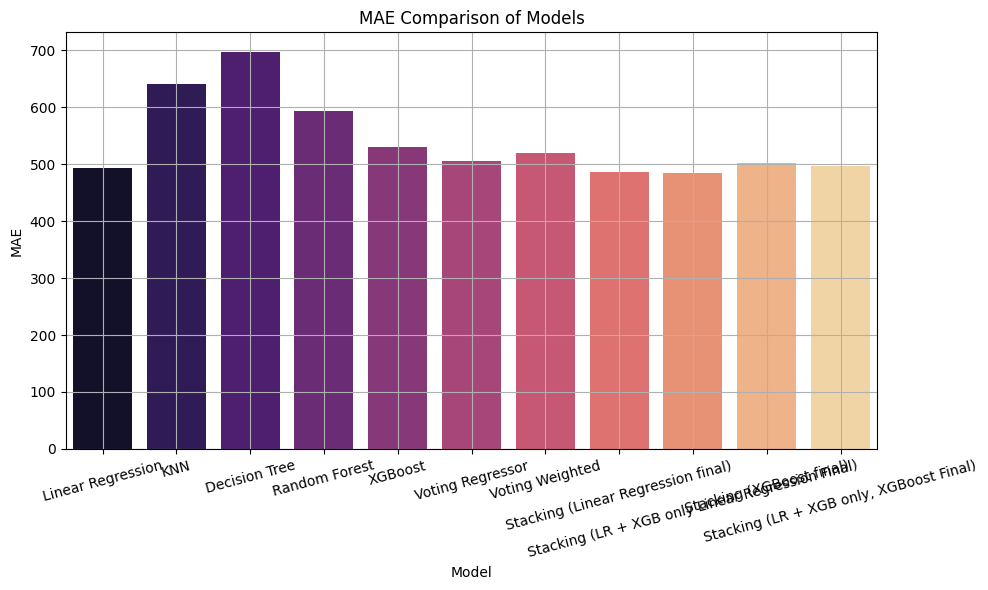

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="MAE", palette="magma")
plt.title("MAE Comparison of Models")
plt.ylabel("MAE")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()
